[View in Colaboratory](https://colab.research.google.com/github/ankanbhunia/Colab/blob/master/final.ipynb)

In [0]:
!python Train.py

In [0]:
import re
import shutil
import tensorflow as tf
from __future__ import division
import matplotlib.pyplot as plt

MP_NAME = 'mp'

params = {'batch_size' : 9,
          'train_log' : 'train_log99',
          'model_dir' : 'model6214414414',
          'output_dir' : 'output',
          'log_device_placement' : False,
          'data_train_gt' : '/content/Data_original/Data_gt/train_gt/',
          'data_train_im' : '/content/Data_original/Data_im/train_im/',
          'data_train_index' : '/content/Data_original/dir_name.txt',
          'num_epochs_per_decay' : 20,
          'learning_rate_per_decay' : 0.9,
          'initial_learning_rate' :1.0e-1
          
          
          
    
}

In [0]:
def _activation_summary(x):

    tensor_name = re.sub('%s_[0-9]*/' % MP_NAME, '', x.op.name)
    tf.summary.histogram(tensor_name + '/activations', x)
    tf.summary.scalar(tensor_name + '/sparsity', tf.nn.zero_fraction(x))


def _variable_on_cpu(name, shape, initializer):

    with tf.device('/gpu:0'):
        var = tf.get_variable(name, shape, initializer=initializer)

    return var


def _variable_with_weight_decay(name, shape, stddev, wd):

    var = _variable_on_cpu(name, shape, tf.random_normal_initializer(stddev=stddev))
    if wd:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)

    return var


class BatchNorm(object):

    def __init__(self, epsilon=1e-5, momentum=0.9, name="batch_norm"):

        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x):

        return tf.contrib.layers.batch_norm(x, decay=self.momentum, updates_collections=None,
                                            epsilon=self.epsilon, scale=True, scope=self.name)


def multi_scale_block(in_con, in_dim, out_dim, is_bn=False):

    with tf.variable_scope('con_9') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[9, 9, in_dim, out_dim],
                                             stddev=0.01, wd=0.0005)
        con_9 = tf.nn.conv2d(in_con, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
        _activation_summary(con_9)

    with tf.variable_scope('con_7') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[7, 7, in_dim, out_dim],
                                             stddev=0.01, wd=0.0005)
        con_7 = tf.nn.conv2d(in_con, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
        _activation_summary(con_7)

    with tf.variable_scope('con_5') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[5, 5, in_dim, out_dim],
                                             stddev=0.01, wd=0.0005)
        con_5 = tf.nn.conv2d(in_con, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
        _activation_summary(con_5)

    with tf.variable_scope('con_3') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[3, 3, in_dim, out_dim],
                                             stddev=0.01, wd=0.0005)
        con_3 = tf.nn.conv2d(in_con, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
        _activation_summary(con_3)

    with tf.variable_scope('concat') as scope:
        concat = tf.concat([con_9, con_7, con_5, con_3], 3, name=scope.name)
        biases = _variable_on_cpu('biases', [out_dim * 4], tf.constant_initializer(0))
        bias = tf.nn.bias_add(concat, biases)

        if is_bn:
            bn = BatchNorm()
            bias = bn(bias)

        msb = tf.nn.relu(bias)
        _activation_summary(msb)

    return msb



def inference_bn(images):
    
    with tf.variable_scope('Network', reuse=tf.AUTO_REUSE):

        with tf.variable_scope('con1') as scope:
            kernel = _variable_with_weight_decay('weights', shape=[9, 9, 3, 64],
                                                 stddev=0.01, wd=0.0005)
            con = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
            biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0))
            bias = tf.nn.bias_add(con, biases)
            con1 = tf.nn.relu(bias)
            _activation_summary(con1)

        # msb_con2
        with tf.variable_scope('msb_con2'):
            msb_con2 = multi_scale_block(con1, 64, 16, is_bn=True)

        # pool_msb_con2
        with tf.variable_scope('pool_msb_con2') as scope:
            pool_msb_con2 = tf.nn.max_pool(msb_con2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                                           name=scope.name)

        # msb_con3
        with tf.variable_scope('msb_con3'):
            msb_con3 = multi_scale_block(pool_msb_con2, 64, 32, is_bn=True)

        # msb_con4
        with tf.variable_scope('msb_con4'):
            msb_con4 = multi_scale_block(msb_con3, 128, 32, is_bn=True)

        # pool_msb_con4
        with tf.variable_scope('pool_msb_con4') as scope:
            pool_msb_con4 = tf.nn.max_pool(msb_con4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                                           name=scope.name)

        # msb_con5
        with tf.variable_scope('msb_con5'):
            msb_con5 = multi_scale_block(pool_msb_con4, 128, 64, is_bn=True)

        # msb_con6
        with tf.variable_scope('msb_con6'):
            msb_con6 = multi_scale_block(msb_con5, 256, 64, is_bn=True)

        # mpl_con7
        with tf.variable_scope('mpl_con7') as scope:
            kernel = _variable_with_weight_decay('weights', shape=[1, 1, 256, 1000], stddev=0.001, wd=0.0005)
            con = tf.nn.conv2d(msb_con6, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
            biases = _variable_on_cpu('biases', [1000], tf.constant_initializer(0))
            bias = tf.nn.bias_add(con, biases)
            mpl_con7 = tf.nn.relu(bias)
            _activation_summary(mpl_con7)

        # con_out
        with tf.variable_scope('con_out') as scope:
            kernel = _variable_with_weight_decay('weights', shape=[1, 1, 1000, 1], stddev=0.001, wd=0.0005)
            con = tf.nn.conv2d(mpl_con7, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
            biases = _variable_on_cpu('biases', [1], tf.constant_initializer(0))
            bias = tf.nn.bias_add(con, biases)

            bn = BatchNorm()
            bias = bn(bias)

            con_out = tf.nn.relu(tf.nn.sigmoid(bias))
            _activation_summary(con_out)

        image_out = con_out

        tf.summary.image("con_img", image_out)

        return image_out


def get_loss(predict, label):

    l2_loss = tf.reduce_sum((predict - label) * (predict - label))

    tf.summary.histogram('loss', l2_loss)

    return l2_loss


def add_avg_loss(avg_loss):

    add_avg_loss_op = avg_loss * 1
    tf.summary.histogram('avg_loss', avg_loss)

    return add_avg_loss_op


def _add_loss_summaries(total_loss):

    loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
    losses = tf.get_collection('losses')
    loss_averages_op = loss_averages.apply(losses + [total_loss])

    for l in losses + [total_loss]:
        tf.summary.scalar(l.op.name + ' (raw)', l)
        tf.summary.scalar(l.op.name, loss_averages.average(l))

    return loss_averages_op


def train(total_loss, global_step, nums_per_train):

    num_batches_per_epoch = nums_per_train / params['batch_size']
    decay_steps = int(num_batches_per_epoch * params['num_epochs_per_decay'])

    lr = tf.train.exponential_decay(params['initial_learning_rate'],
                                    global_step,
                                    decay_steps,
                                    params['learning_rate_per_decay'],
                                    staircase=True)
    tf.summary.scalar('learning_rate', lr)

  
    opt = tf.train.RMSPropOptimizer(lr)
    grads = opt.compute_gradients(total_loss)


    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)
    train_op = apply_gradient_op

    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)

    return train_op

In [0]:
class batch_norm(object):
            # h1 = lrelu(tf.contrib.layers.batch_norm(conv2d(h0, self.df_dim*2, name='d_h1_conv'),decay=0.9,updates_collections=None,epsilon=0.00001,scale=True,scope="d_h1_conv"))
    def __init__(self, epsilon=0.001, momentum = 0, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x, train=True):
        return tf.contrib.layers.batch_norm(x, decay=self.momentum, updates_collections=None, epsilon=self.epsilon, scale=True, scope=self.name)

def conv2d(input_, output_dim, 
           k_h=5, k_w=5, d_h=1, d_w=1, stddev=0.02,
           name="conv2d",relu = True, bn = True):
    
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.bias_add(conv, biases)
        if relu:
            conv  = tf.nn.relu(conv)
        if bn:
            bnF = batch_norm(name = name+'_bn')
            conv = bnF(conv)
        
        return conv

In [0]:
def inference_bn_(Input):
    
    with tf.variable_scope('Network', reuse=tf.AUTO_REUSE):

        with tf.variable_scope('Branch1') as scope:

            Branch1_conv1 = conv2d(Input, 16, 9, 9, name = 'conv1')
            Branch1_pool1 = tf.layers.max_pooling2d(Branch1_conv1, 2, 2, padding = 'same')
            Branch1_conv2 = conv2d(Branch1_pool1, 32, 7, 7, name = 'conv2')
            Branch1_pool2 = tf.layers.max_pooling2d(Branch1_conv2, 2, 2, padding = 'same')
            Branch1_conv3 = conv2d(Branch1_pool2, 16, 7, 7, name = 'conv3')
            Branch1_conv4 = conv2d(Branch1_conv3, 8, 7, 7, name = 'conv4')

        with tf.variable_scope('Branch2') as scope:

            Branch2_conv1 = conv2d(Input, 20, 7, 7, name = 'conv1')
            Branch2_pool1 = tf.layers.max_pooling2d(Branch2_conv1, 2, 2, padding = 'same')
            Branch2_conv2 = conv2d(Branch2_pool1, 40, 5, 5, name = 'conv2')
            Branch2_pool2 = tf.layers.max_pooling2d(Branch2_conv2, 2, 2, padding = 'same')
            Branch2_conv3 = conv2d(Branch2_pool2, 20, 5, 5, name = 'conv3')
            Branch2_conv4 = conv2d(Branch2_conv3, 10, 5, 5, name = 'conv4')

        with tf.variable_scope('Branch3') as scope:

            Branch3_conv1 = conv2d(Input, 24, 5, 5, name = 'conv1')
            Branch3_pool1 = tf.layers.max_pooling2d(Branch3_conv1, 2, 2, padding = 'same')
            Branch3_conv2 = conv2d(Branch3_pool1, 48, 3, 3, name = 'conv2')
            Branch3_pool2 = tf.layers.max_pooling2d(Branch3_conv2, 2, 2, padding = 'same')
            Branch3_conv3 = conv2d(Branch3_pool2, 24, 3, 3, name = 'conv3')
            Branch3_conv4 = conv2d(Branch3_conv3, 12, 3, 3, name = 'conv4')

        with tf.variable_scope('fuse') as scope:

            Fuse = tf.concat([Branch1_conv4, Branch2_conv4, Branch3_conv4],-1)
            Out = conv2d(Fuse, 1, 1, 1, name = 'Out')

        return tf.nn.relu(tf.nn.sigmoid(Out))

In [0]:
def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides = [1, 1, 1, 1], padding = 'SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

def inf(x):
  
  
  with tf.variable_scope('Network', reuse=tf.AUTO_REUSE):
    
      # s net ###########################################################
      w_conv1_1 = tf.get_variable('w_conv1_1', [5, 5, 3, 24])
      b_conv1_1 = tf.get_variable('b_conv1_1', [24])
      h_conv1_1 = tf.nn.relu(conv2d(x, w_conv1_1) + b_conv1_1)

      h_pool1_1 = max_pool_2x2(h_conv1_1)

      w_conv2_1 = tf.get_variable('w_conv2_1', [3, 3, 24, 48])
      b_conv2_1 = tf.get_variable('b_conv2_1', [48])
      h_conv2_1 = tf.nn.relu(conv2d(h_pool1_1, w_conv2_1) + b_conv2_1)

      h_pool2_1 = max_pool_2x2(h_conv2_1)

      w_conv3_1 = tf.get_variable('w_conv3_1', [3, 3, 48, 24])
      b_conv3_1 = tf.get_variable('b_conv3_1', [24])
      h_conv3_1 = tf.nn.relu(conv2d(h_pool2_1, w_conv3_1) + b_conv3_1)

      w_conv4_1 = tf.get_variable('w_conv4_1', [3, 3, 24, 12])
      b_conv4_1 = tf.get_variable('b_conv4_1', [12])
      h_conv4_1 = tf.nn.relu(conv2d(h_conv3_1, w_conv4_1) + b_conv4_1)

      # m net ###########################################################
      w_conv1_2 = tf.get_variable('w_conv1_2', [7, 7, 3, 20])
      b_conv1_2 = tf.get_variable('b_conv1_2', [20])
      h_conv1_2 = tf.nn.relu(conv2d(x, w_conv1_2) + b_conv1_2)

      h_pool1_2 = max_pool_2x2(h_conv1_2)

      w_conv2_2 = tf.get_variable('w_conv2_2', [5, 5, 20, 40])
      b_conv2_2 = tf.get_variable('b_conv2_2', [40])
      h_conv2_2 = tf.nn.relu(conv2d(h_pool1_2, w_conv2_2) + b_conv2_2)

      h_pool2_2 = max_pool_2x2(h_conv2_2)

      w_conv3_2 = tf.get_variable('w_conv3_2', [5, 5, 40, 20])
      b_conv3_2 = tf.get_variable('b_conv3_2', [20])
      h_conv3_2 = tf.nn.relu(conv2d(h_pool2_2, w_conv3_2) + b_conv3_2)

      w_conv4_2 = tf.get_variable('w_conv4_2', [5, 5, 20, 10])
      b_conv4_2 = tf.get_variable('b_conv4_2', [10])
      h_conv4_2 = tf.nn.relu(conv2d(h_conv3_2, w_conv4_2) + b_conv4_2)

      # l net ###########################################################
      w_conv1_3 = tf.get_variable('w_conv1_3', [9, 9, 3, 16])
      b_conv1_3 = tf.get_variable('b_conv1_3', [16])
      h_conv1_3 = tf.nn.relu(conv2d(x, w_conv1_3) + b_conv1_3)

      h_pool1_3 = max_pool_2x2(h_conv1_3)

      w_conv2_3 = tf.get_variable('w_conv2_3', [7, 7, 16, 32])
      b_conv2_3 = tf.get_variable('b_conv2_3', [32])
      h_conv2_3 = tf.nn.relu(conv2d(h_pool1_3, w_conv2_3) + b_conv2_3)

      h_pool2_3 = max_pool_2x2(h_conv2_3)

      w_conv3_3 = tf.get_variable('w_conv3_3', [7, 7, 32, 16])
      b_conv3_3 = tf.get_variable('b_conv3_3', [16])
      h_conv3_3 = tf.nn.relu(conv2d(h_pool2_3, w_conv3_3) + b_conv3_3)

      w_conv4_3 = tf.get_variable('w_conv4_3', [7, 7, 16, 8])
      b_conv4_3 = tf.get_variable('b_conv4_3', [8])
      h_conv4_3 = tf.nn.relu(conv2d(h_conv3_3, w_conv4_3) + b_conv4_3)

      # merge ###########################################################
      h_conv4_merge = tf.concat([h_conv4_1, h_conv4_2, h_conv4_3], 3)

      w_conv5 = tf.get_variable('w_conv5', [1, 1, 30, 1])
      b_conv5 = tf.get_variable('b_conv5', [1])
      h_conv5 = conv2d(h_conv4_merge, w_conv5) + b_conv5

      y_pre = h_conv5

      return y_pre

In [0]:
def get_ranking_loss(predicts, gt):
    
    counts = [tf.squeeze(i,[0]) for i in tf.split(predicts,params['batch_size'],0)]
    counts_gt = [tf.squeeze(i,[0]) for i in tf.split(gt,params['batch_size'],0)]
 
    
    def _ranking_loss_(i_c,j_c,i_gt,j_gt):
        return tf.cond(i_gt<j_gt, lambda: tf.maximum(0.0, i_c - j_c), lambda: tf.maximum(0.0, j_c - i_c))

    import itertools
    ranking_loss = 0
    
    for i,j in itertools.combinations(np.arange(params['batch_size']), 2):
        ranking_loss = ranking_loss + _ranking_loss_(tf.reduce_sum(counts[i]), tf.reduce_sum(counts[j]), tf.reduce_sum(counts_gt[i]), tf.reduce_sum(counts_gt[j]))
    
    return ranking_loss

In [139]:
tf.split(tf.placeholder(tf.float32, [32, None,None,3]),32,0)

[<tf.Tensor 'split_1:0' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:1' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:2' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:3' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:4' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:5' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:6' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:7' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:8' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:9' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:10' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:11' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:12' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:13' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:14' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:15' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:16' shape=(1, ?, ?, 3) dtype=

In [0]:
Ndef get_data(dir_name):
  
  nums_train = len(dir_name)
  
  num_batch = np.random.choice(nums_train,1)#random.sample(range(nums_train), nums_train)[0:params['batch_size']]

  xs, ys = [], []

  for index in num_batch:

      file_name = dir_name[index]
      im_name, gt_name = file_name.split(' ')
      gt_name = gt_name.split('\n')[0]


      batch_xs = cv2.imread(params['data_train_im'] + im_name)
      batch_xs = (np.array(batch_xs, dtype=np.float32))


      batch_ys = np.array(np.load(params['data_train_gt'] + gt_name))
      batch_ys = np.array(batch_ys, dtype=np.float32)
      batch_ys = batch_ys.reshape([batch_ys.shape[0], batch_ys.shape[1], -1])



      if np.random.choice(2)==1:
        batch_xs = cv2.flip(batch_xs,1)
        batch_ys = cv2.flip(batch_ys,1)
        if len(batch_ys.shape)==2:
          batch_ys = np.expand_dims(batch_ys,-1)


      


      xs.append(batch_xs)
      ys.append(batch_ys)

  np_xs_ = np.array(xs)
  np_ys_ = np.array(ys)

  _,w,h,_ = np_xs_.shape

  randw = np.random.random()
  randh = np.random.random()

  W0 = int(randw*(w-int(w//1.1)))
  H0 = int(randh*(h-int(h//1.1)))


  np_xs = np_xs_[:,W0:W0+int(w//1.1),H0:H0+int(h//1.1),:]

  np_ys = np_ys_[:,W0//4:W0//4+np.ceil(int(w//1.1)/4).astype('int'),H0//4:H0//4+np.ceil(int(h//1.1)/4).astype('int'),:]
  
  return np_xs, np_ys


In [0]:
def get_data(dir_name):
  
  nums_train = len(dir_name)
  
  num_batch = np.random.choice(nums_train,9)#random.sample(range(nums_train), nums_train)[0:params['batch_size']]
  
  hw = []

  xs, ys = [], []

  for index in num_batch:

      file_name = dir_name[index]
      im_name, gt_name = file_name.split(' ')
      gt_name = gt_name.split('\n')[0]


      batch_xs = cv2.imread(params['data_train_im'] + im_name)
      batch_xs = (np.array(batch_xs, dtype=np.float32))


      batch_ys = np.array(np.load(params['data_train_gt'] + gt_name))
      batch_ys = np.array(batch_ys, dtype=np.float32)
      batch_ys = batch_ys.reshape([batch_ys.shape[0], batch_ys.shape[1], -1])

      w,h,_ = batch_xs.shape

      hw.append([w,h])


      xs.append(batch_xs)
      ys.append(batch_ys)
      
  hw = np.array(hw)
  w0,h0 = np.min(hw[:,0]), np.min(hw[:,1])
  print (w0,h0)
  
  xs_, ys_ = [], []
  for batch_xs,batch_ys in zip(xs,ys):
    
    if np.random.choice(2)==1:
        batch_xs = cv2.flip(batch_xs,1)
        batch_ys = cv2.flip(batch_ys,1)
        if len(batch_ys.shape)==2:
          batch_ys = np.expand_dims(batch_ys,-1)

    w,h,_ = batch_xs.shape

    randw = np.random.random()
    randh = np.random.random()

    W0 = int(randw*(w-w0))
    H0 = int(randh*(h-h0))


    batch_xs = batch_xs[W0:W0+w0,H0:H0+h0,:]

    batch_ys = batch_ys[W0//4:W0//4+np.ceil(w0/4).astype('int'),H0//4:H0//4+np.ceil(h0/4).astype('int'),:]

    xs_.append(batch_xs)
    ys_.append(batch_ys)
    

  np_xs = np.stack(xs_,0)
  np_ys = np.stack(ys_,0)


  
  return np_xs, np_ys


In [0]:
if np.random.choice(2)==1:
        batch_xs = cv2.flip(batch_xs,1)
        batch_ys = cv2.flip(batch_ys,1)
        if len(batch_ys.shape)==2:
          batch_ys = np.expand_dims(batch_ys,-1)

        w,h,_ = batch_xs.shape

        randw = np.random.random()
        randh = np.random.random()

        W0 = int(randw*(w-int(w//1.1)))
        H0 = int(randh*(h-int(h//1.1)))


        batch_xs = batch_xs[W0:W0+int(w//1.1),H0:H0+int(h//1.1),:]

        batch_ys = batch_ys[W0//4:W0//4+np.ceil(int(w//1.1)/4).astype('int'),H0//4:H0//4+np.ceil(int(h//1.1)/4).astype('int'),:]


In [0]:
ff = get_data(dir_name)
 

In [128]:
ff[0].shape

(1, 698, 930, 3)

In [113]:
ff[0][1].shape

(653, 460, 3)

INFO:tensorflow:Restoring parameters from model6214414414/skip_mcnn.ckpt-0
(512, 480)
223.33899
##0 >> avg_loss:245.3023834	 GT:36.3781929	 predict:42.8236046


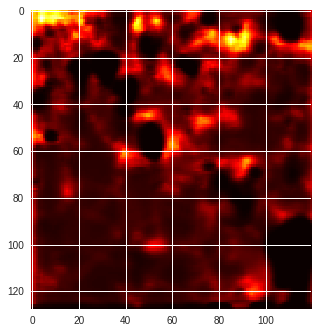

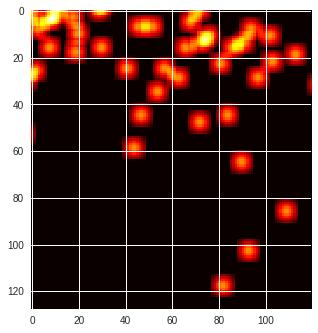

(505, 768)
161.43723
##1 >> avg_loss:460.5372314	 GT:48.3686333	 predict:69.7465897


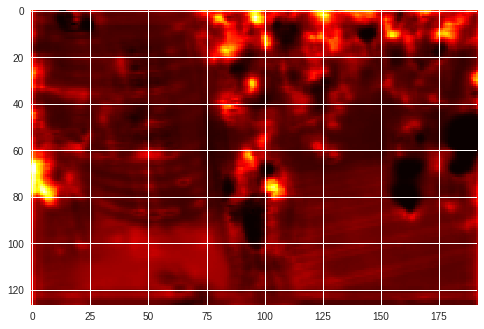

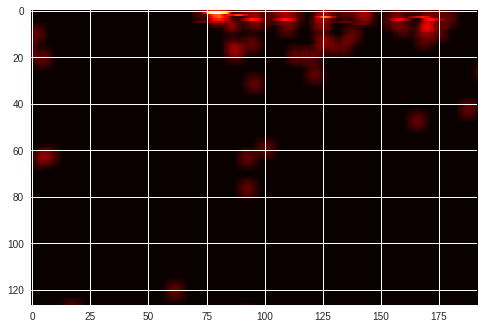

(689, 998)
247.65848
##2 >> avg_loss:301.4635315	 GT:31.4667091	 predict:103.7966766


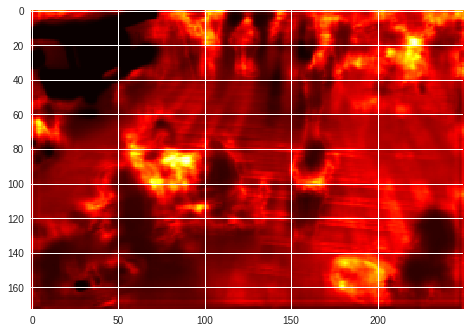

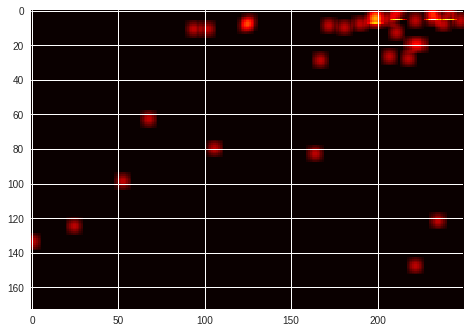

(279, 400)
77.51488
##3 >> avg_loss:99.5932770	 GT:102.2837296	 predict:36.9937363


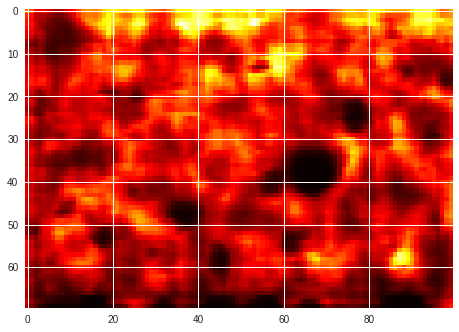

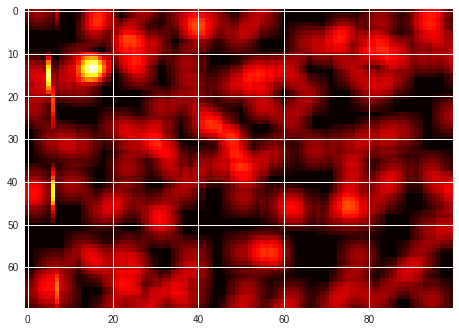

(462, 390)
16.088388
##4 >> avg_loss:140.3050079	 GT:41.5777473	 predict:20.7316895


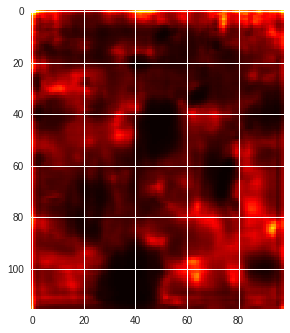

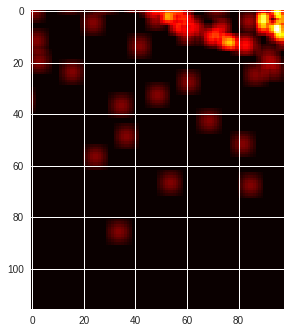

(565, 849)
252.82112
##5 >> avg_loss:465.5906982	 GT:17.5152245	 predict:39.7859688


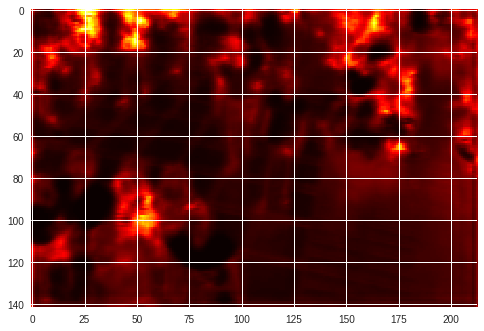

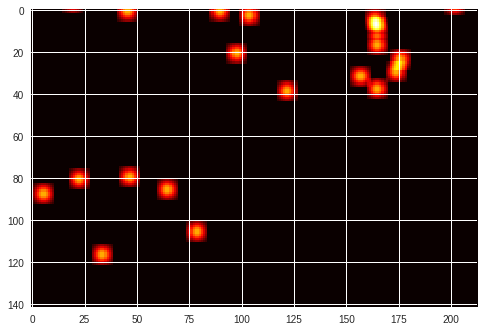

(359, 329)
50.08438
##6 >> avg_loss:129.2089539	 GT:36.3697701	 predict:19.4922180


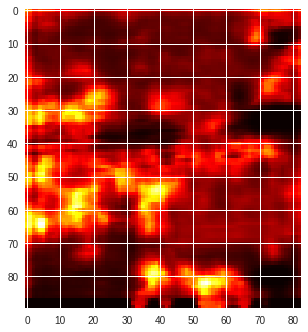

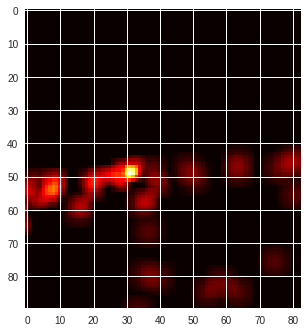

(182, 420)
13.607434
##7 >> avg_loss:80.6974335	 GT:354.0000610	 predict:36.4806366


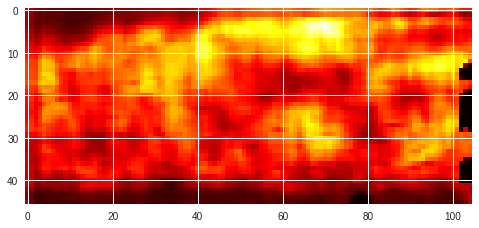

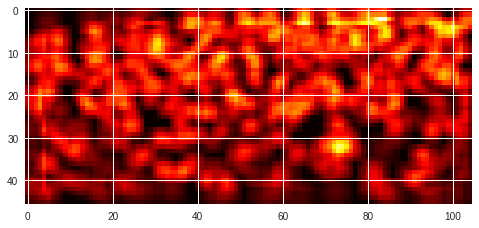

(426, 634)
14.981852
##8 >> avg_loss:22.8262100	 GT:8.6074047	 predict:20.0368576


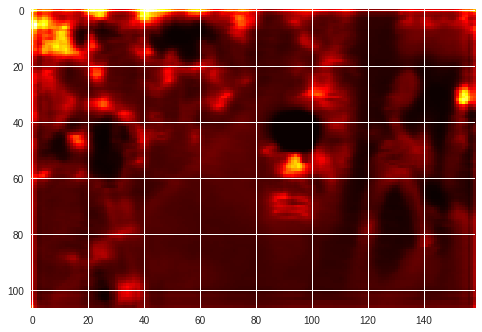

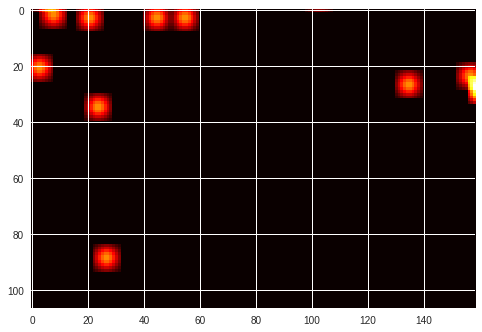

(625, 1024)
75.02498
##9 >> avg_loss:217.8615112	 GT:27.4990463	 predict:51.0863762


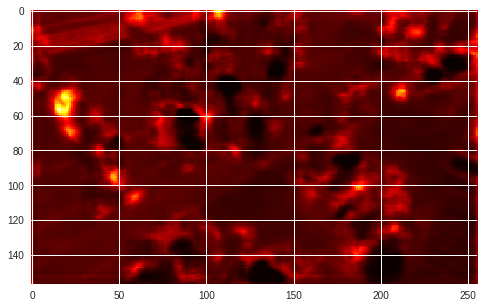

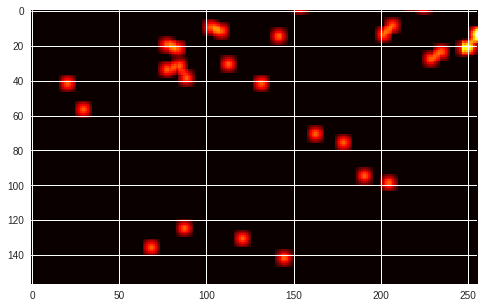

(536, 800)
53.94683
##10 >> avg_loss:100.9403076	 GT:24.3629017	 predict:37.9894676


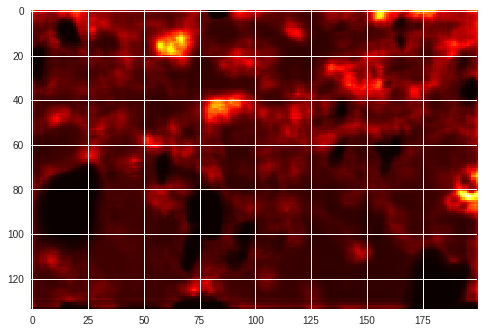

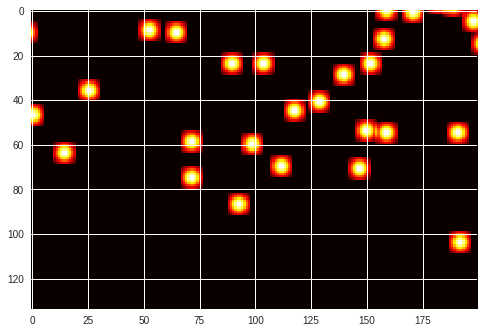

(449, 716)
9.371651
##11 >> avg_loss:92.0993652	 GT:47.2425995	 predict:23.0663891


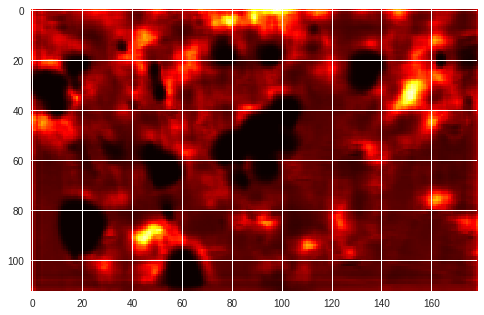

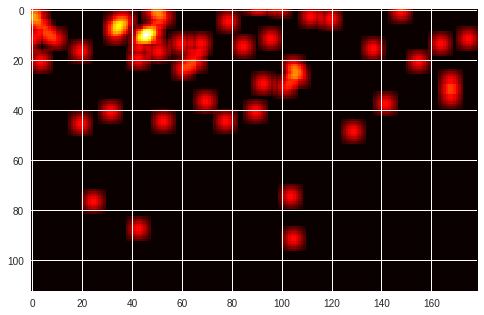

(351, 620)
24.107231
##12 >> avg_loss:52.6924744	 GT:60.1141968	 predict:25.2979031


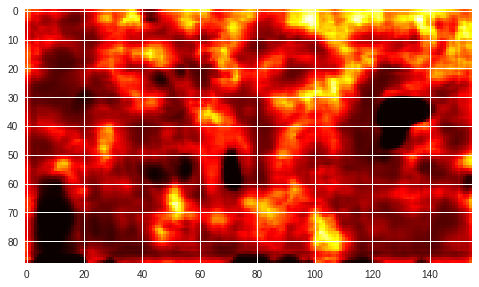

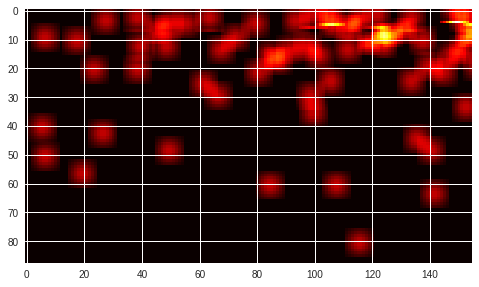

(522, 600)
24.293121
##13 >> avg_loss:392.6965027	 GT:101.2006989	 predict:27.5040169


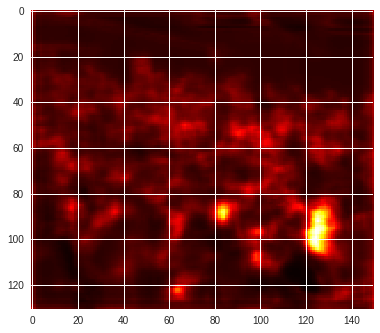

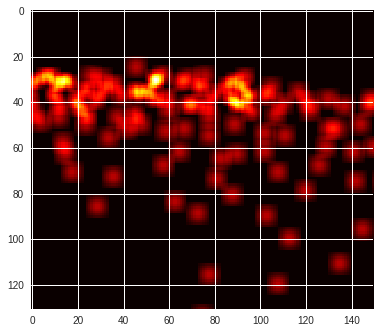

(338, 506)
1.4766665
##14 >> avg_loss:17.1617470	 GT:2.9999998	 predict:11.0494156


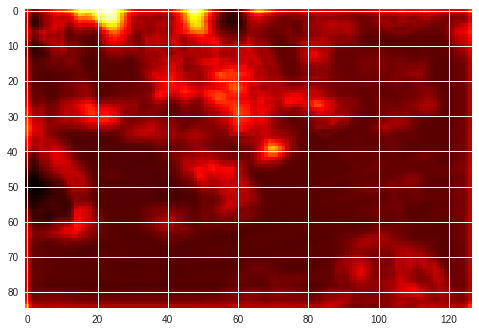

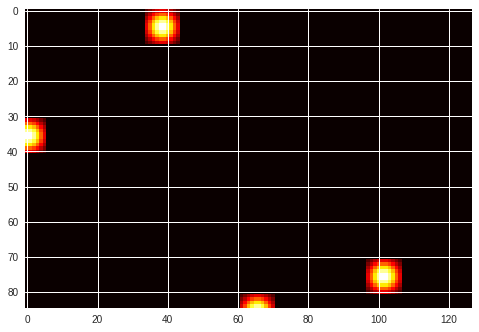

(282, 432)
14.514217
##15 >> avg_loss:87.6405182	 GT:8.4046926	 predict:6.6990995


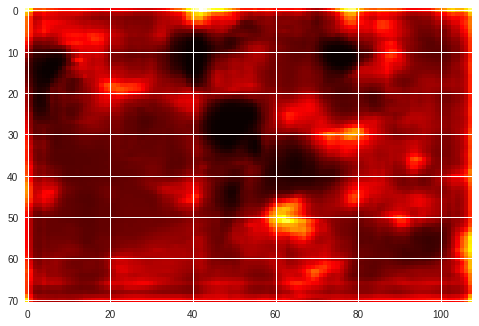

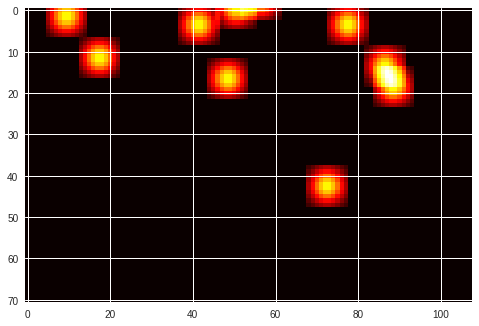

(450, 970)
1.1371078
##16 >> avg_loss:237.6003113	 GT:38.3864174	 predict:31.9858627


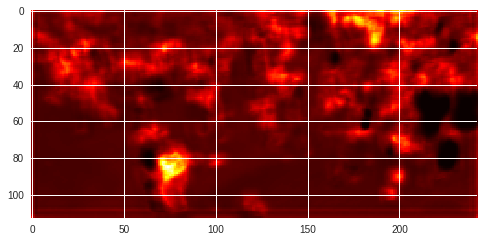

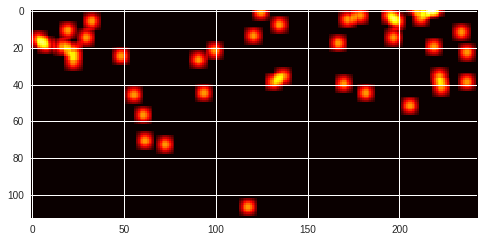

(661, 1024)
12.587555
##17 >> avg_loss:144.8835297	 GT:29.9523315	 predict:50.0681343


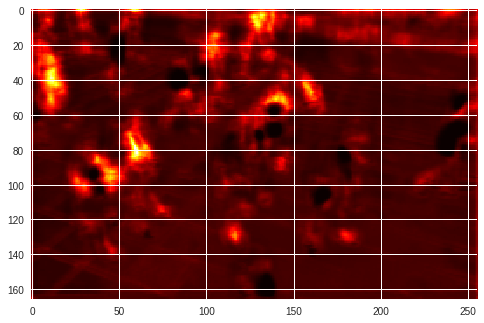

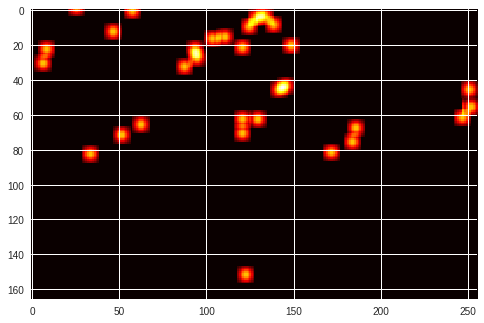

(530, 840)
74.310074
##18 >> avg_loss:165.4819489	 GT:623.9822998	 predict:90.3657913


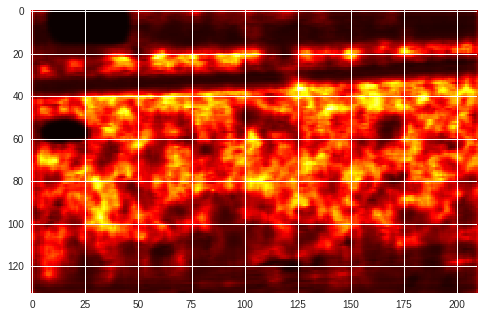

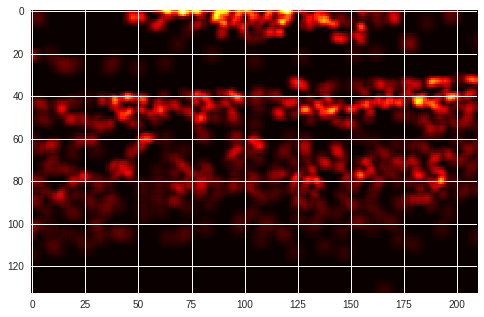

(405, 540)
57.9225
##19 >> avg_loss:103.6053925	 GT:36.9579544	 predict:12.5937548


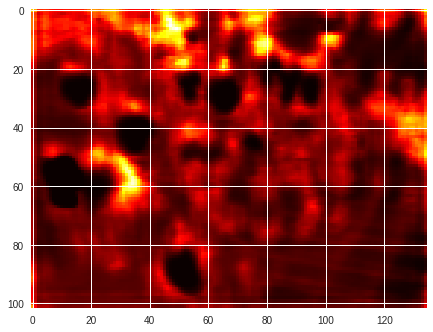

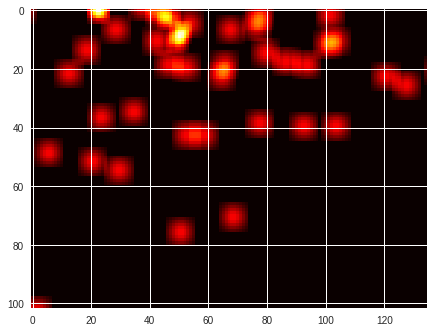

(272, 511)
1.3998499
##20 >> avg_loss:207.8483124	 GT:5.6212134	 predict:8.6696873


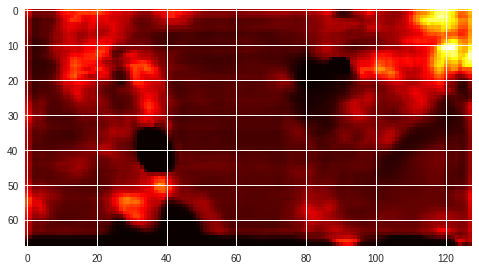

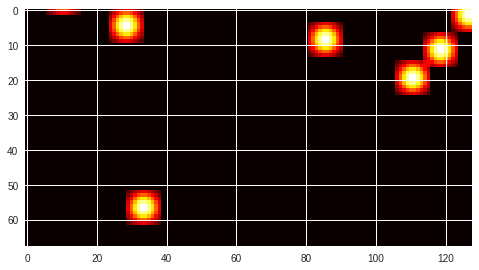

(645, 1024)
65.7843
##21 >> avg_loss:79.7625427	 GT:15.2484884	 predict:38.0778503


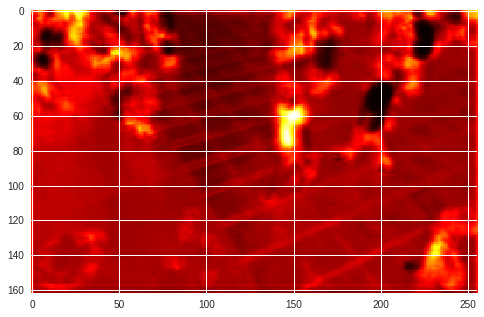

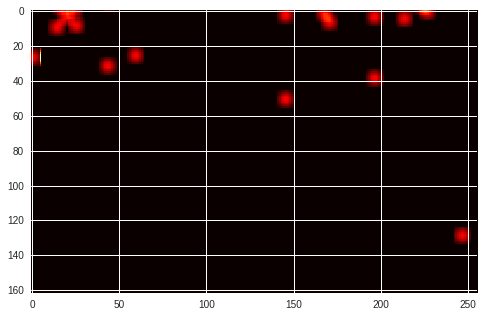

(680, 1024)
4.26202
##22 >> avg_loss:160.8928375	 GT:215.2668610	 predict:63.3167038


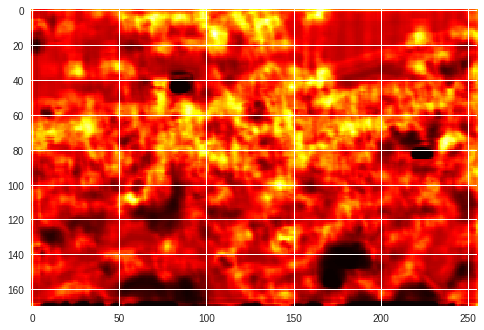

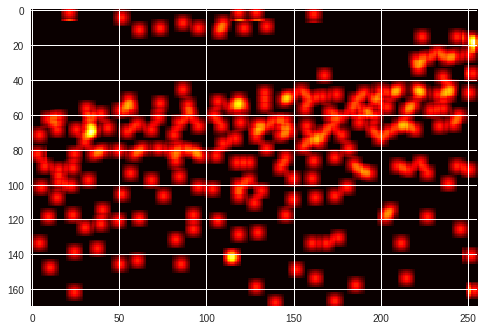

(300, 416)
21.488937
##23 >> avg_loss:60.0776596	 GT:49.1605873	 predict:9.1766739


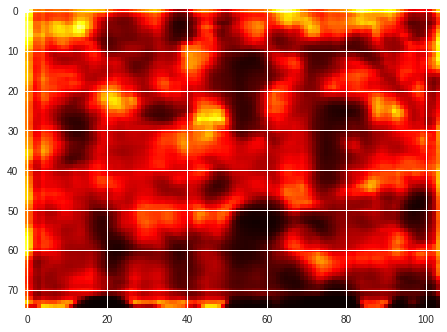

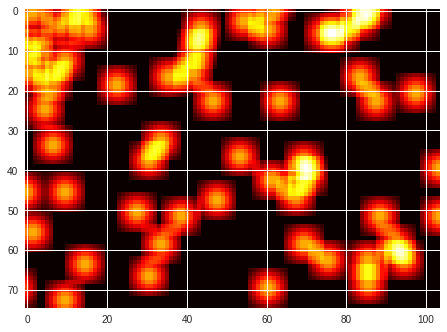

(663, 962)
11.279182
##24 >> avg_loss:148.9648132	 GT:186.3076172	 predict:65.4977417


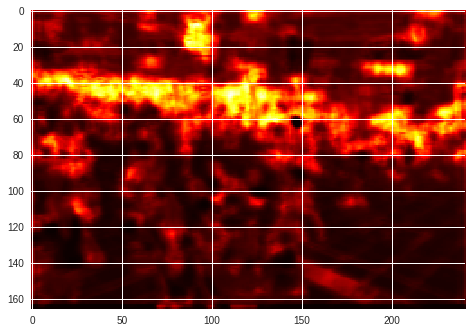

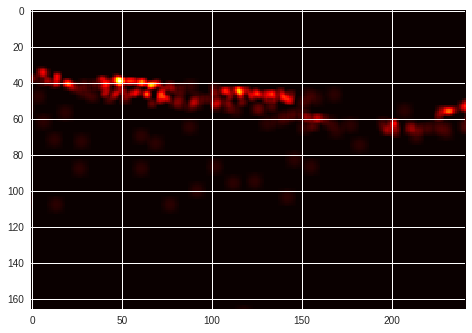

(478, 359)
10.7661915
##25 >> avg_loss:107.9281693	 GT:60.3449669	 predict:31.8726349


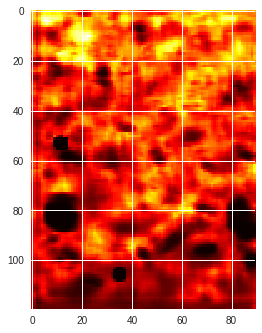

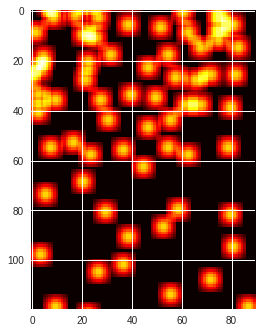

(267, 400)
37.102768
##26 >> avg_loss:184.2414856	 GT:0.0000000	 predict:5.1051641


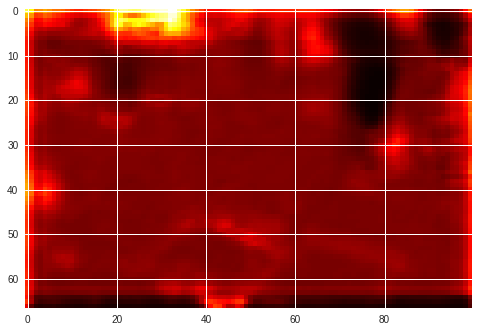

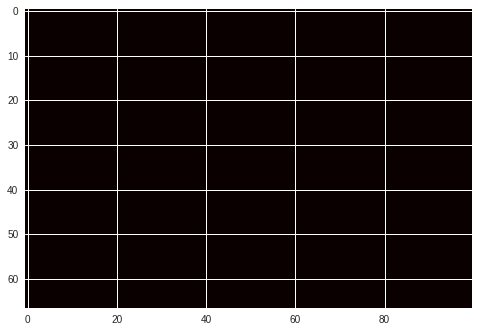

(598, 460)
49.11981
##27 >> avg_loss:608.9940796	 GT:17.0726910	 predict:10.4508934


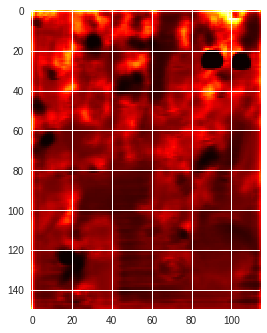

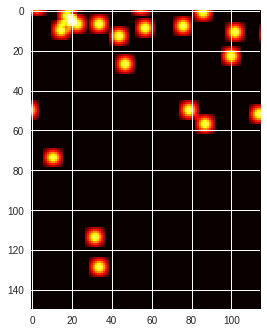

(338, 329)
1.5928669
##28 >> avg_loss:100.2862244	 GT:67.2145309	 predict:6.2912483


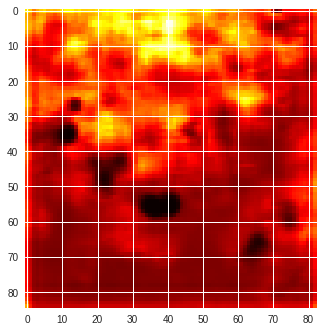

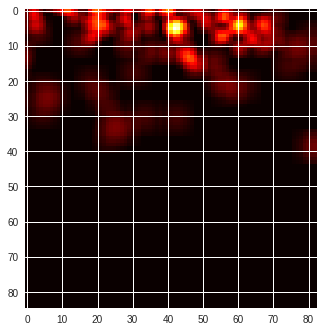

(713, 1024)
49.02324
##29 >> avg_loss:251.6889191	 GT:151.0000458	 predict:42.9969864


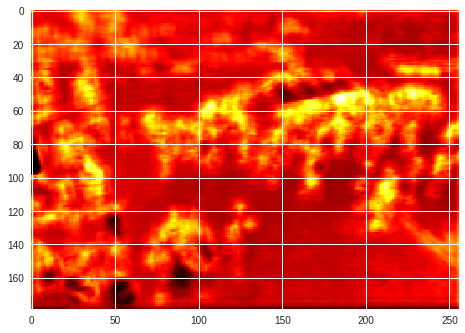

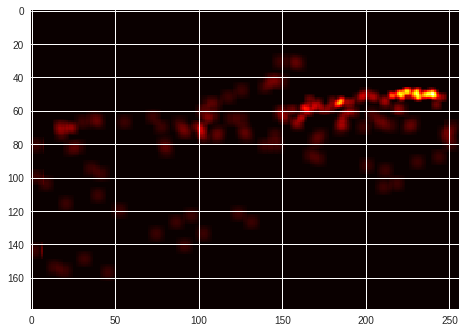

(360, 540)
0.0
##30 >> avg_loss:106.7818909	 GT:160.1461945	 predict:18.2721424


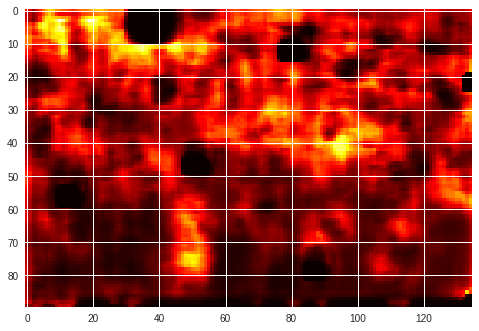

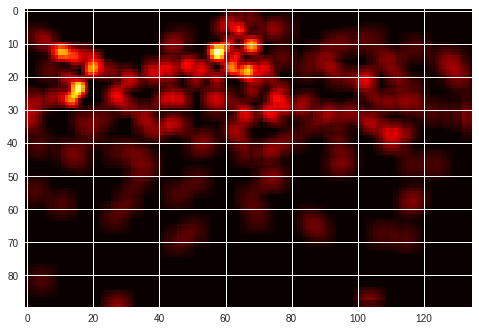

(300, 400)
3.775474
##31 >> avg_loss:9.2056046	 GT:32.0068054	 predict:13.6309137


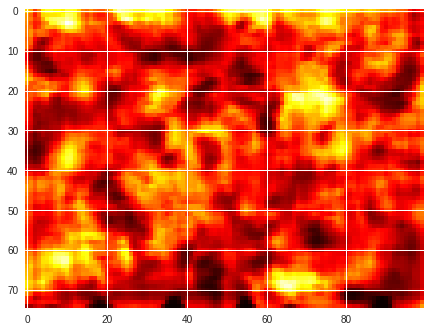

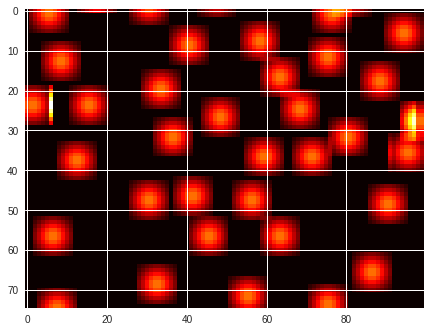

(338, 506)
5.346352
##32 >> avg_loss:75.7674179	 GT:36.6985970	 predict:8.2329264


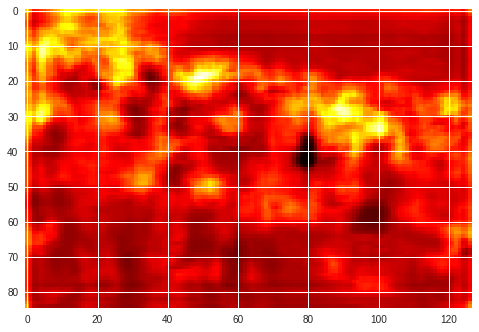

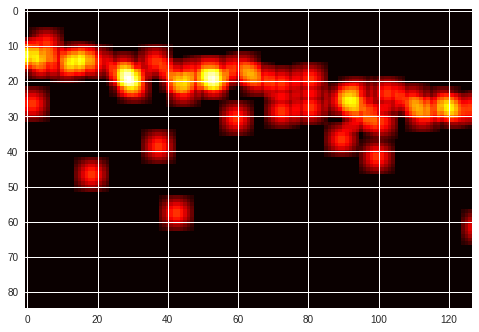

(498, 600)
12.146664
##33 >> avg_loss:35.3461876	 GT:208.1472626	 predict:29.5902710


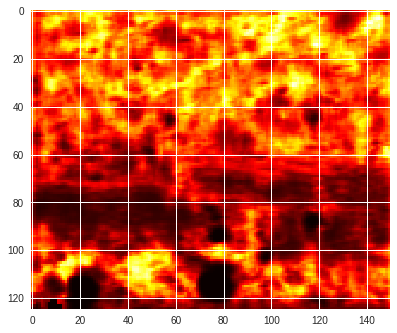

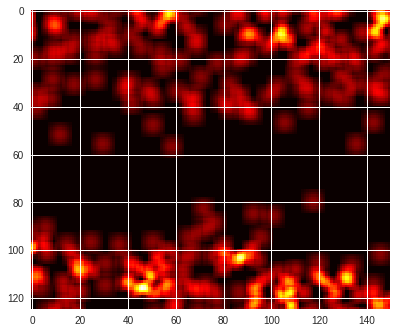

(405, 609)
8.495942
##34 >> avg_loss:37.3504105	 GT:168.3123016	 predict:17.1209717


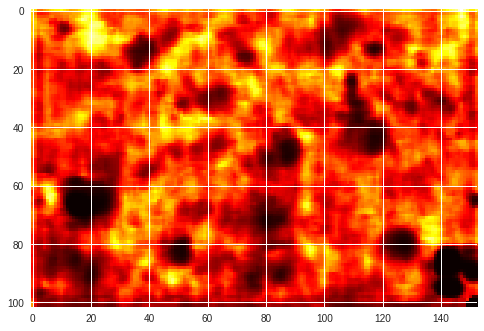

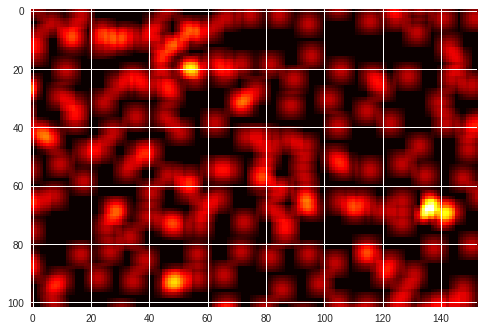

(576, 832)
12.246962
##35 >> avg_loss:194.7380219	 GT:190.4907074	 predict:29.7557411


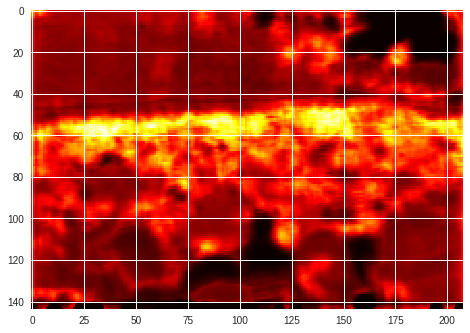

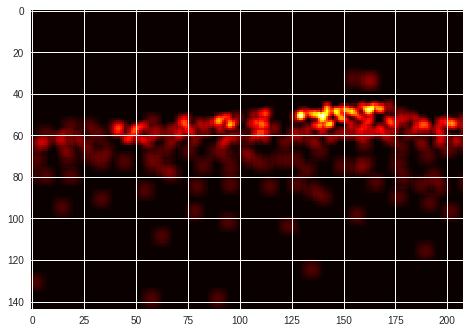

(616, 620)
20.787521
##36 >> avg_loss:44.3735962	 GT:71.8175735	 predict:22.3708611


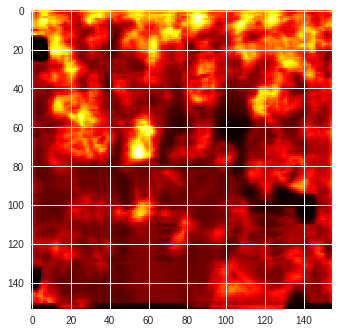

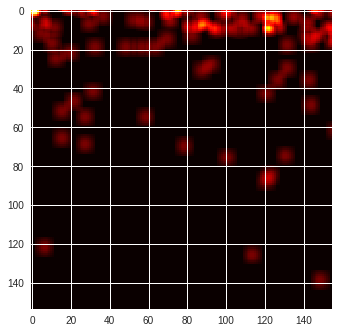

(267, 400)
4.8541408
##37 >> avg_loss:133.2086945	 GT:5.6191921	 predict:5.1023159


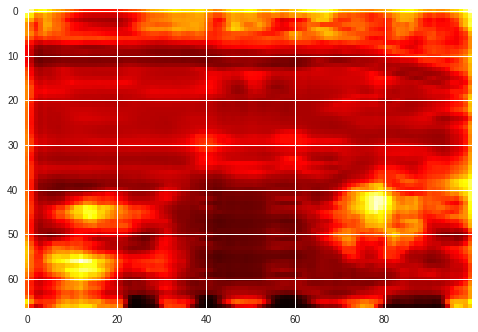

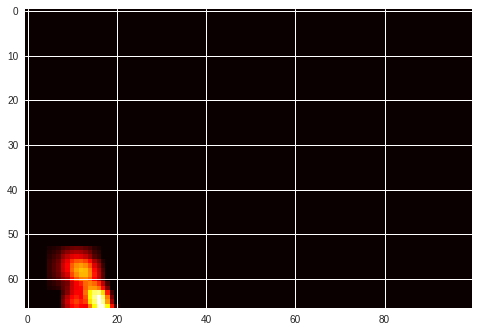

(667, 1000)
22.579472
##38 >> avg_loss:247.7235413	 GT:209.8799438	 predict:37.1332626


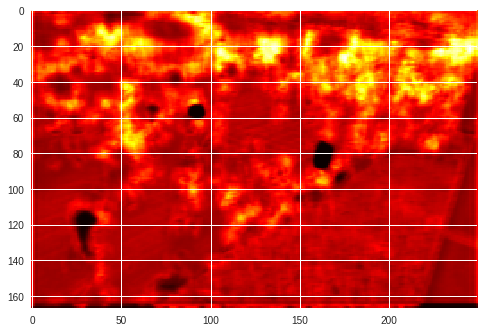

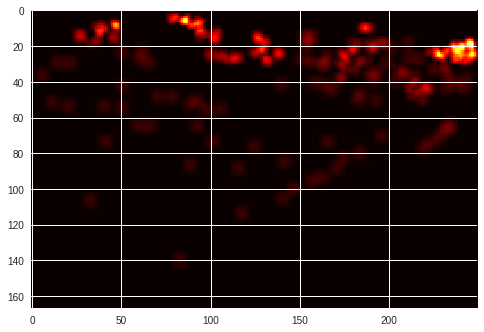

(380, 594)
9.7427435
##39 >> avg_loss:95.0451736	 GT:13.1219797	 predict:7.7016187


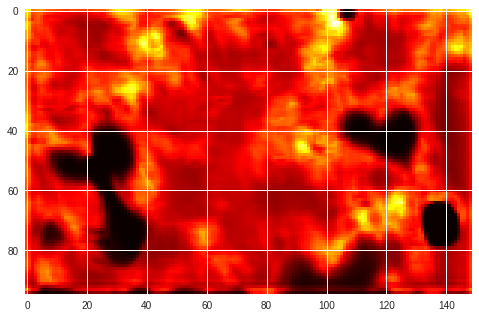

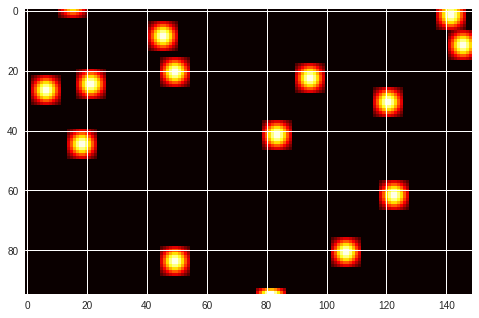

(267, 496)
9.881415
##40 >> avg_loss:25.2331390	 GT:58.0625191	 predict:9.8726492


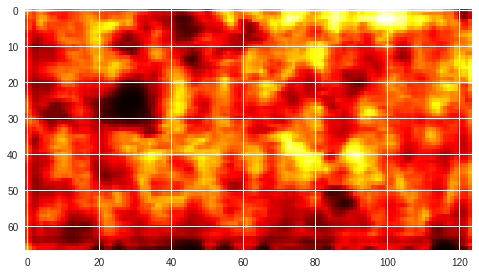

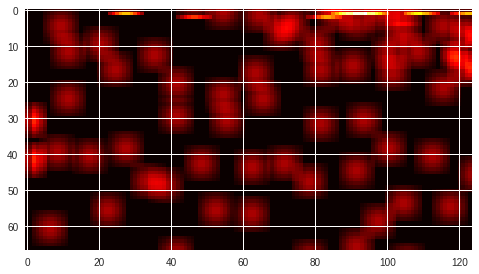

(387, 580)
12.363419
##41 >> avg_loss:388.2033081	 GT:254.0000000	 predict:13.8778191


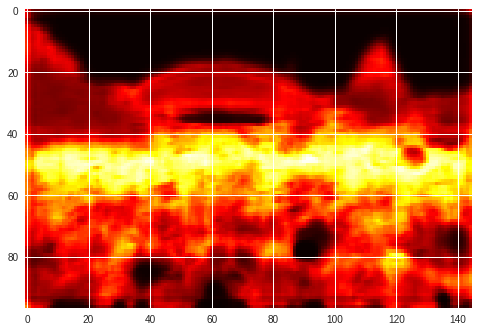

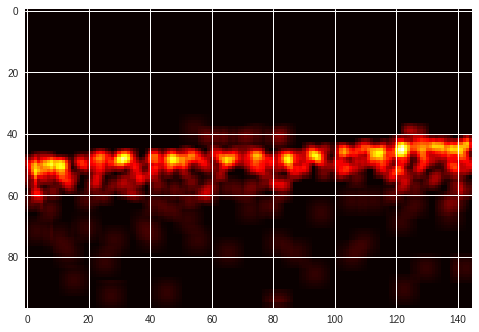

(576, 832)
12.385857
##42 >> avg_loss:301.8865967	 GT:1691.5540771	 predict:42.4781952


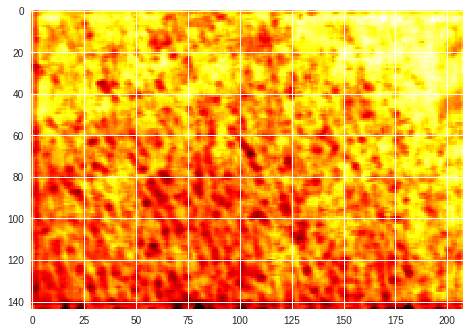

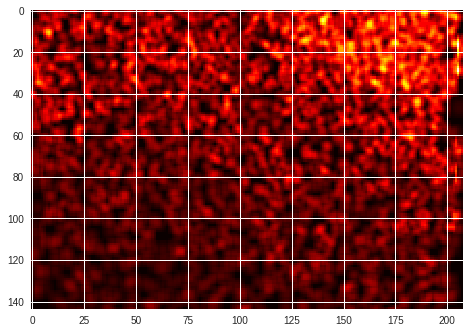

(334, 299)
5.510179
##43 >> avg_loss:183.9325104	 GT:1.0000000	 predict:3.1546488


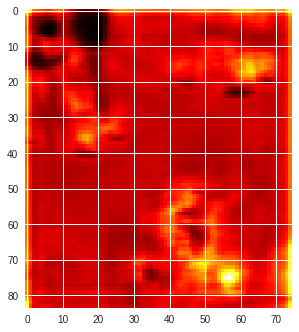

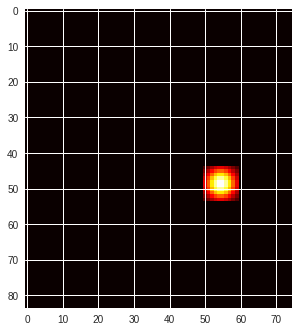

(478, 359)
2.487042
##44 >> avg_loss:6.7984281	 GT:46.7406273	 predict:7.3561444


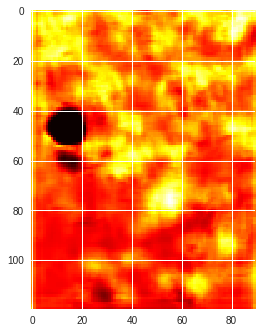

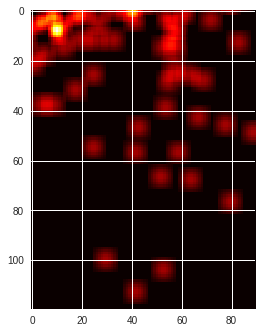

(380, 594)
6.3523393
##45 >> avg_loss:725.1199951	 GT:223.6794434	 predict:9.8579435


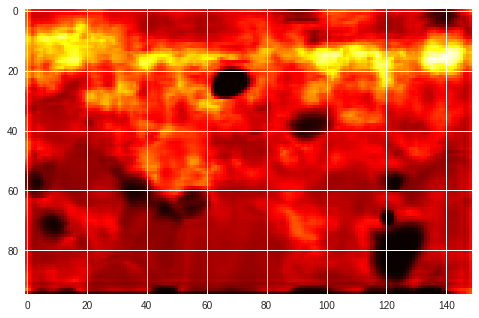

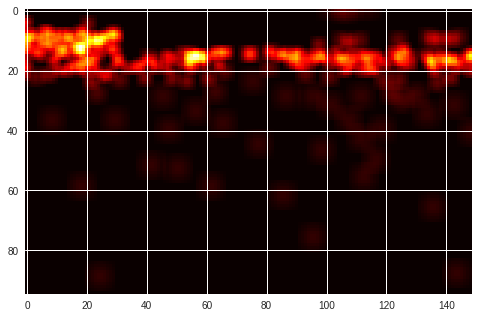

(683, 600)
2.4007015
##46 >> avg_loss:26.2894154	 GT:20.3781338	 predict:14.8093596


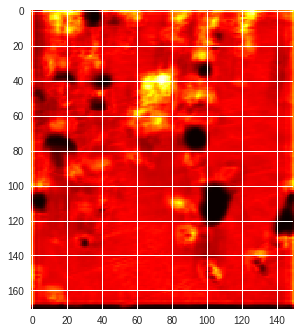

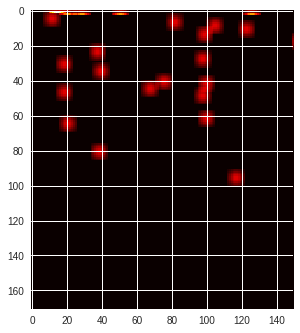

(682, 1024)
32.013443
##47 >> avg_loss:173.3257751	 GT:709.6107788	 predict:30.4259872


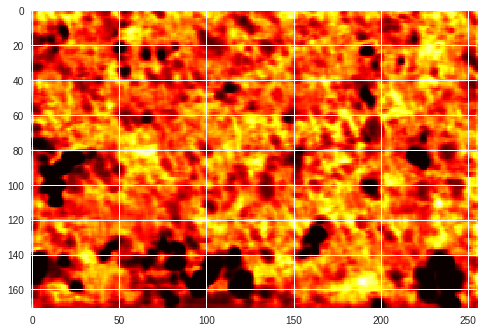

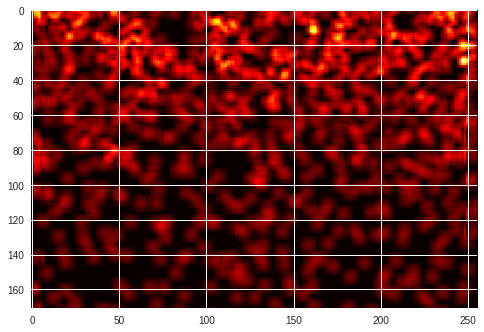

(377, 709)
14.67407
##48 >> avg_loss:185.3376465	 GT:280.8571777	 predict:8.4869242


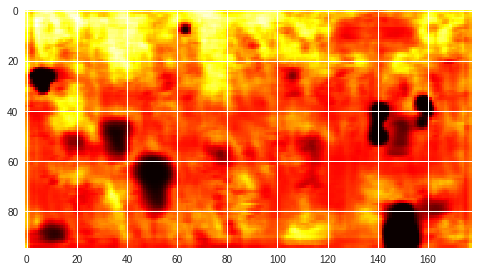

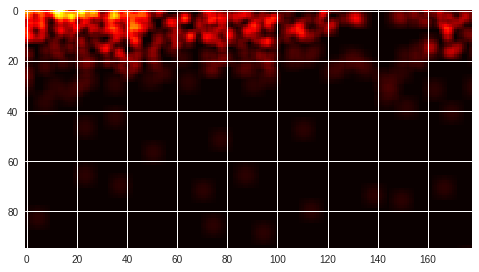

(450, 722)
0.062381744
##49 >> avg_loss:168.6395264	 GT:28.7256966	 predict:10.8380499


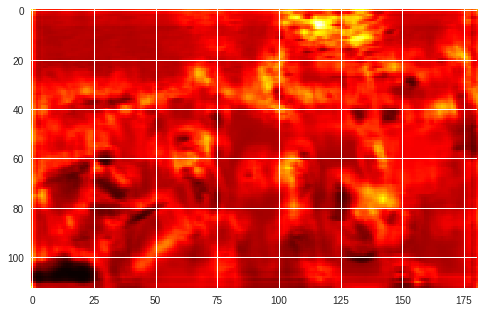

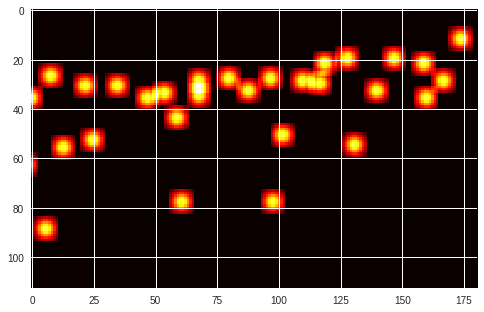

(327, 609)
15.292341
##50 >> avg_loss:329.2814026	 GT:6.7560472	 predict:5.7682366


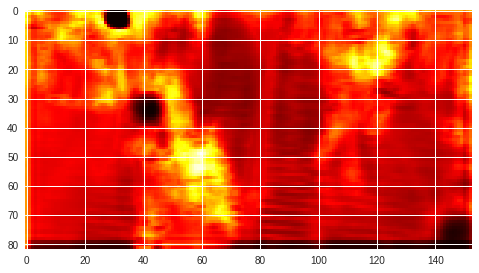

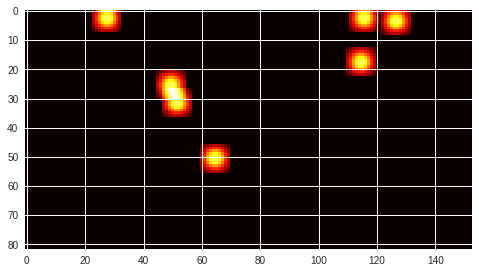

(328, 605)
6.4636836
##51 >> avg_loss:442.0634766	 GT:86.6588745	 predict:7.4547839


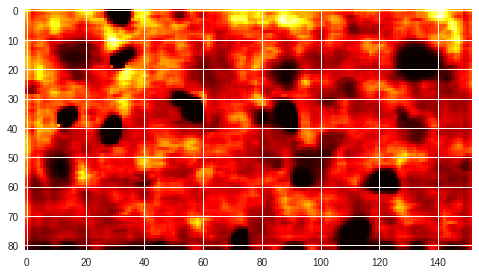

KeyboardInterrupt: ignored

In [150]:

import os.path
import random
import cv2
from six.moves import xrange

import tensorflow as tf
from tensorflow.python.platform import gfile
import numpy as np


num_epochs_per_decay = 20
learning_rate_per_decay = 0.9
initial_learning_rate = 1.0e-1


def Compile():
    fig = plt.figure()
    with tf.Graph().as_default():
        
        dir_file = open(params['data_train_index'])
        dir_name = dir_file.readlines()

    
        nums_train = len(dir_name)
        global_step = tf.Variable(0, trainable=False)

   
        image = tf.placeholder("float",[params['batch_size'],None,None,3])
        label = tf.placeholder("float",[params['batch_size'],None,None,1])
        avg_loss = tf.placeholder("float")

        predicts = inference_bn_(image) 
        rnking_loss = get_ranking_loss(predicts, label)
        loss = get_loss(predicts, label)  + rnking_loss
        train_op = train(loss, global_step, nums_train)  

        sess = tf.Session()  
        saver = tf.train.Saver(tf.all_variables())  

        init = tf.initialize_all_variables()  
        sess.run(init)  

        checkpoint_dir = tf.train.get_checkpoint_state(params['model_dir'])
        if checkpoint_dir and checkpoint_dir.model_checkpoint_path:
            saver.restore(sess, checkpoint_dir.model_checkpoint_path)
        else:
            print('Not found checkpoint file')

        summary_op = tf.summary.merge_all() 
        add_avg_loss_op = add_avg_loss(avg_loss)  
        summary_writer = tf.summary.FileWriter(params['train_log'], graph_def=sess.graph_def)

        steps = 100000
        avg_loss_1 = 0

        for step in xrange(steps):
            #if step < nums_train * 10:
               
              #  num_batch = [divmod(step, nums_train)[1] + i for i in range(params['batch_size'])]
                
            #else:
               
            np_xs, np_ys = get_data(dir_name)
         
            _, loss_value, rnking_loss_ = sess.run([train_op, loss, rnking_loss], feed_dict={image: np_xs, label: np_ys})
            print (rnking_loss_)
            output = sess.run(predicts, feed_dict={image: np_xs})
            avg_loss_1 += loss_value

            if step % 100 == 0:
              
                summary_str = sess.run(summary_op, feed_dict={image: np_xs, label: np_ys,
                                                              avg_loss: avg_loss_1 / 100})
                summary_writer.add_summary(summary_str, step)
                avg_loss_1 = 0

            if step % 1 == 0:
              
                print("##"+str(step)+" >> avg_loss:%.7f\t GT:%.7f\t predict:%.7f" % \
                      (loss_value, sum(sum(sum(np_ys[0]))), sum(sum(sum(output[0])))))
                
                sess.run(add_avg_loss_op, feed_dict={avg_loss: loss_value})
                
                plt.imshow(output[0,:,:,0],cmap = 'hot')

                plt.show()
                plt.imshow(np_ys[0,:,:,0] ,cmap = 'hot')

                plt.show()
                
                

            if step % 2000 == 0:
                checkpoint_path = os.path.join(params['model_dir'], 'skip_mcnn.ckpt')
                saver.save(sess, checkpoint_path, global_step=step)

            if step % 500 == 0:
                out_path = os.path.join(params['output_dir'], str(step) + "out.npy")
                np.save(out_path, output)


def main(argv=None):
    if gfile.Exists(params['train_log']):
        shutil.rmtree(params['train_log'],ignore_errors=True)
    gfile.MakeDirs(params['train_log'])

    if not gfile.Exists(params['model_dir']):
        gfile.MakeDirs(params['model_dir'])

    if not gfile.Exists(params['output_dir']):
        gfile.MakeDirs(params['output_dir'])

    Compile()


if __name__ == '__main__':
    tf.app.run()


Not found checkpoint file
2343.7656
##0 >> avg_loss:253613.5625000	 ranking loss: 	 GT:1322.6855469	 predict:15192.7900391


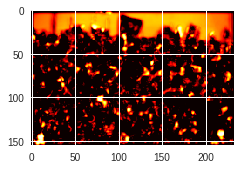

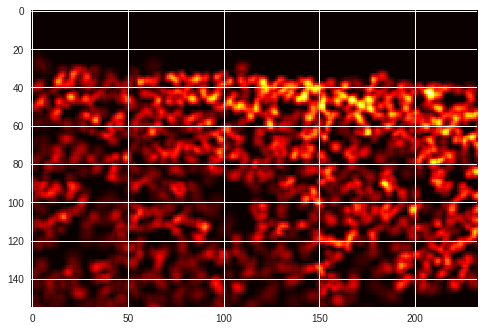

0.0
##500 >> avg_loss:74.1225510	 ranking loss: 	 GT:74.6332016	 predict:0.0002534


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


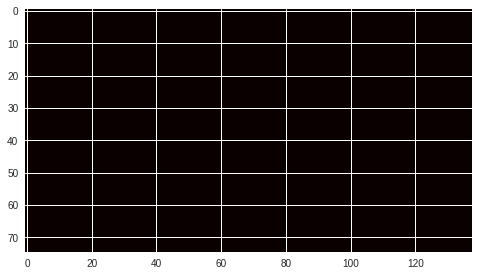

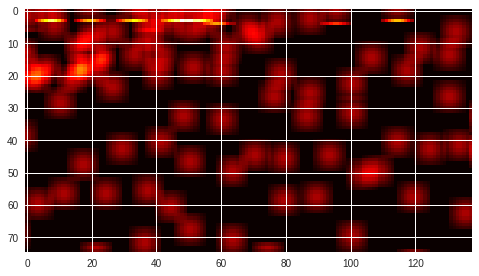

0.0
##1000 >> avg_loss:17.9543018	 ranking loss: 	 GT:246.9154358	 predict:0.0000000


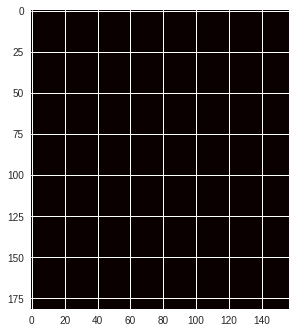

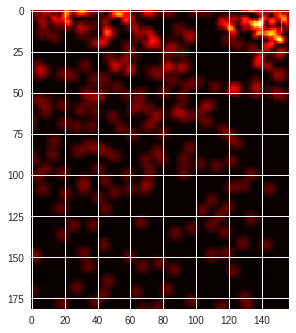

KeyboardInterrupt: ignored

In [26]:

import os.path
import random
import cv2
from six.moves import xrange

import tensorflow as tf
from tensorflow.python.platform import gfile
import numpy as np


num_epochs_per_decay = 20
learning_rate_per_decay = 0.9
initial_learning_rate = 1.0e-1


def Compile():
    fig = plt.figure()
    with tf.Graph().as_default():
        
        dir_file = open(params['data_train_index'])
        dir_name = dir_file.readlines()

    
        nums_train = len(dir_name)
        global_step = tf.Variable(0, trainable=False)

   
        image1 = tf.placeholder("float",[None,None,None,3])
        label1 = tf.placeholder("float",[None,None,None,1])
      
        image2= tf.placeholder("float",[None,None,None,3])
        label2= tf.placeholder("float",[None,None,None,1])
        
        
        avg_loss = tf.placeholder("float")

        predicts1= inference_bn_(image1)  
        loss1 = get_loss(predicts1, label1)  
                                 
        predicts2 =  inference_bn_(image2)  
        loss2 = get_loss(predicts2, label2)
        
        rnkng_loss = _ranking_loss_(tf.reduce_sum(predicts1),tf.reduce_sum(predicts2),tf.reduce_sum(label1),tf.reduce_sum(label2))
        
        loss = loss1 + loss2 + 100 * rnkng_loss
        
        train_op = train(loss, global_step, nums_train)  

        sess = tf.Session()  
        saver = tf.train.Saver(tf.all_variables())  

        init = tf.initialize_all_variables()  
        sess.run(init)  

        checkpoint_dir = tf.train.get_checkpoint_state(params['model_dir'])
        if checkpoint_dir and checkpoint_dir.model_checkpoint_path:
            saver.restore(sess, checkpoint_dir.model_checkpoint_path)
        else:
            print('Not found checkpoint file')

        summary_op = tf.summary.merge_all() 
        add_avg_loss_op = add_avg_loss(avg_loss)  
        summary_writer = tf.summary.FileWriter(params['train_log'], graph_def=sess.graph_def)

        steps = 100000
        avg_loss_1 = 0

        for step in xrange(steps):
            
            
            np_xs, np_ys = get_data(dir_name)
            np_xs2, np_ys2 = get_data(dir_name)
              
         
            _, loss_value,_rnkng_loss = sess.run([train_op, loss, rnkng_loss], feed_dict={image1: np_xs, label1: np_ys, image2: np_xs2, label2: np_ys2})
            output = sess.run(predicts1, feed_dict={image1: np_xs})
            avg_loss_1 += loss_value

            if step % 100 == 0:
              
                summary_str = sess.run(summary_op, feed_dict={image1: np_xs, label1: np_ys, image2: np_xs2, label2: np_ys2,
                                                              avg_loss: avg_loss_1 / 100})
                summary_writer.add_summary(summary_str, step)
                avg_loss_1 = 0

            if step % 500 == 0:
                
                print (_rnkng_loss)
              
                print("##"+str(step)+" >> avg_loss:%.7f\t ranking loss: \t GT:%.7f\t predict:%.7f" % \
                      (loss_value, sum(sum(sum(np_ys))), sum(sum(sum(output)))))
                
                sess.run(add_avg_loss_op, feed_dict={avg_loss: loss_value})
                
                
                fig.add_subplot(121)   #top left
                
                plt.imshow(output[0,:,:,0], cmap ='hot')
                plt.show()
                
                fig.add_subplot(122)   #top right

        
                plt.imshow(np_ys[0,:,:,0], cmap ='hot')
                plt.show()
                
                #plt.imshow(np.concatenate([output[0,:,:,0],np_ys[0,:,:,0] ],1),cmap = 'hot')

                #plt.show()
                

            if step % 2000 == 0:
                checkpoint_path = os.path.join(params['model_dir'], 'skip_mcnn.ckpt')
                saver.save(sess, checkpoint_path, global_step=step)

            if step % 500 == 0:
                out_path = os.path.join(params['output_dir'], str(step) + "out.npy")
                np.save(out_path, output)


def main(argv=None):
    if gfile.Exists(params['train_log']):
        shutil.rmtree(params['train_log'],ignore_errors=True)
    gfile.MakeDirs(params['train_log'])

    if not gfile.Exists(params['model_dir']):
        gfile.MakeDirs(params['model_dir'])

    if not gfile.Exists(params['output_dir']):
        gfile.MakeDirs(params['output_dir'])

    Compile()


if __name__ == '__main__':
    tf.app.run()


In [0]:
def _ranking_loss_(i_c,j_c,i_gt,j_gt):
        return tf.cond(i_gt<j_gt, lambda: tf.maximum(0.0, i_c - j_c), lambda: tf.maximum(0.0, j_c - i_c))

In [0]:
def get_ranking_loss(counts, counts_gt):
    
    def _ranking_loss_(i_c,j_c,i_gt,j_gt):
        return tf.cond(i_gt<j_gt, lambda: tf.maximum(0.0, i_c - j_c), lambda: tf.maximum(0.0, j_c - i_c))

    import itertools
    ranking_loss = 0
    
    for i,j in itertools.combinations(np.arange(9), 2):
        ranking_loss = ranking_loss + _ranking_loss_(counts[i], counts[j], counts_gt[i], counts_gt[j])
    
    return ranking_loss

In [0]:

import os.path
import random
import cv2
from six.moves import xrange

import tensorflow as tf
from tensorflow.python.platform import gfile
import numpy as np





def Compile():

    with tf.Graph().as_default():
        
        dir_file = open(params['data_train_index'])
        dir_name = dir_file.readlines()

    
        nums_train = len(dir_name)
        global_step = tf.Variable(0, trainable=False)

   
        image = tf.placeholder("float",[None,None,None,3])
        label = tf.placeholder("float",[None,None,None,1])
        avg_loss = tf.placeholder("float")
        
        W = tf.placeholder(tf.int32)
        H = tf.placeholder(tf.int32)
        
        losses = []
        densities = []
        gt_densities = []
        counts = []
        counts_gt = []
        
        MAEs = []
        MSEs = []
        
        for i in range(9):
            
            randw = np.random.random()
            randh = np.random.random()
            
            W0 = tf.cast(randw*tf.cast(W-W//4, tf.float32),tf.int32)
            H0 = tf.cast(randh*tf.cast(H-H//4, tf.float32),tf.int32)

            patch_img = image[:,W0:W0+W//4,H0:H0+H//4,:]
            patch_lab = label[:,W0//4:W0//4+tf.cast(tf.ceil((W//4)/4),tf.int32),H0//4:H0//4+tf.cast(tf.ceil((H//4)/4),tf.int32),:]
        
            patch_density = inf(patch_img)
            
            patch_count = tf.reduce_sum(patch_density)
            
            tf.summary.image('lab'+str(i+1),patch_lab,1)
            tf.summary.image('out'+str(i+1),patch_density,1)
            
            patch_count_gt = tf.reduce_sum(patch_lab)
            
            MAE_ = tf.abs(patch_count - patch_count_gt)
            MSE_ = tf.square(patch_count - patch_count_gt)
        
            losses.append(get_loss(patch_density, patch_lab))

            
            densities.append(patch_density)
            gt_densities.append(patch_lab)
            
            counts.append(patch_count)
            counts_gt.append(patch_count_gt)
            
            MAEs.append(MAE_)
            MSEs.append(MSE_)
            
            
        MAE = tf.reduce_sum(MAEs)
        MSE = tf.reduce_sum(MSEs)
        
        ranking_loss = get_ranking_loss(counts, counts_gt)
        

        loss = tf.reduce_sum(losses) +  100 * ranking_loss
        train_op = train(loss, global_step, nums_train)  
        
        sess = tf.Session()  
        saver = tf.train.Saver(tf.all_variables())  

        init = tf.initialize_all_variables()  
        sess.run(init)  

        checkpoint_dir = tf.train.get_checkpoint_state(params['model_dir'])
        
        if checkpoint_dir and checkpoint_dir.model_checkpoint_path:
            saver.restore(sess, checkpoint_dir.model_checkpoint_path)
        else:
            print('Not found checkpoint file')

        summary_op = tf.summary.merge_all() 
        add_avg_loss_op = add_avg_loss(avg_loss)  
        summary_writer = tf.summary.FileWriter(params['train_log'], graph_def=sess.graph_def)

        steps = 100000
        avg_loss_1 = 0
        
        _MAE_ = 0
        _MSE_ = 0

        for step in xrange(steps):
            if step < nums_train * 10:
               
                num_batch = [divmod(step, nums_train)[1] + i for i in range(params['batch_size'])]
            else:
               
                num_batch = random.sample(range(nums_train), nums_train)[0:params['batch_size']]

            xs, ys = [], []
            for index in num_batch:
                
                file_name = dir_name[index]
                im_name, gt_name = file_name.split(' ')
                gt_name = gt_name.split('\n')[0]

               
                batch_xs = cv2.imread(params['data_train_im'] + im_name)
                batch_xs = (np.array(batch_xs, dtype=np.float32))

                
                batch_ys = np.array(np.load(params['data_train_gt'] + gt_name))
                batch_ys = np.array(batch_ys, dtype=np.float32)
                batch_ys = batch_ys.reshape([batch_ys.shape[0], batch_ys.shape[1], -1])

                xs.append(batch_xs)
                ys.append(batch_ys)
                
            np_xs = np.array(xs)
            np_ys = np.array(ys)
  
            _,w,h,_ = np_xs.shape
            _, loss_value, ranking_loss_, MAE_metric, MSE_metric = sess.run([train_op, loss, ranking_loss, MAE, MSE], feed_dict={image: np_xs, label: np_ys, W:w , H:h})
            output, _label = sess.run([densities, gt_densities], feed_dict={image: np_xs, label: np_ys, W:w , H:h})
            avg_loss_1 += loss_value
            _MAE_ += MAE_metric
            _MSE_ += MSE_metric
            
            if step % 500 == 0:
                summary_str = sess.run(summary_op, feed_dict={image: np_xs, label: np_ys,
                                                              avg_loss: avg_loss_1 / 500, W:w , H:h})
                summary_writer.add_summary(summary_str, step)
                print ('')
                print ('#############################################')
                print ('')
                print ('## Step : ' + str(step) + ' Train MAE : ' + str(_MAE_/500) + ' Train MSE : ' + str(np.sqrt(_MSE_/500)))
                print ('')
                print ('#############################################')
                print ('')
                avg_loss_1 = 0
                _MAE_ = 0
                _MSE_ = 0
            
            if step % 100 == 0:
                print("## Step : " +str(step)+" avg_loss:%.7f\t GT:%.7f\t predict:%.7f" % \
                      (loss_value, np.sum(np.array(_label)), np.sum(np.array(output))))
                sess.run(add_avg_loss_op, feed_dict={avg_loss: loss_value, W:w , H:h})
       
                plt.imshow(np.concatenate([output[0][0,:,:,0], _label[0][0,:,:,0]],1),cmap = 'hot')
                plt.show()

            if step % 2000 == 0:
                checkpoint_path = os.path.join(params['model_dir'], 'skip_mcnn.ckpt')
                saver.save(sess, checkpoint_path, global_step=step)

            #if step % 500 == 0:
             #   out_path = os.path.join(params['output_dir'], str(step) + "out.npy")
              #  np.save(out_path, output)


def main(argv=None):
    if gfile.Exists(params['train_log']):
        shutil.rmtree(params['train_log'],ignore_errors=True)
    gfile.MakeDirs(params['train_log'])

    if not gfile.Exists(params['model_dir']):
        gfile.MakeDirs(params['model_dir'])

    if not gfile.Exists(params['output_dir']):
        gfile.MakeDirs(params['output_dir'])

    Compile()


if __name__ == '__main__':
    tf.app.run()

TypeError: ignored

In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
tf.reset_default_graph()

In [0]:
!ls

shutil.rmtree(params['train_log'],ignore_errors=True)

Colabstart.py	gdfuse.zip	ngrok			      train_log4
datalab		Init.ipynb	ngrok-stable-linux-amd64.zip  trash.py
DLSETUP_.ipynb	localtunnel.rb	output
drive		model2		starting_script.ipynb
